# 와인 가격 논리적인 가격인가?
- 딥러닝 과정이 들어가야 하는 데이터
- 자연어 처리를 어떻게 하느냐에 따라 선형회귀 모델이 달라짐.
- 라벨인코더,원핫인코더 = 설명력이 0.8, RMSE가 낮게 나옴.

In [1]:
!pip install kneed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# 클러스터링 하기 위해 KMeans 가져옴. 

from sklearn.metrics import mean_squared_error, r2_score
# 선형회귀에서 가장 중요한 지표, RMSE, R2 score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
# polynomia : 컬럼들을 다항회귀용으로 만들어줌.

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
# 클러스터링 한 후에, 시각화 할 때 뜨는 TSNE

from kneed import KneeLocator
from scipy.stats import f_oneway
from itertools import combinations

/Users/t2023-m0093/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.options.display.max_columns = 99
df = pd.read_csv('cleansingWine.csv')
df.isna().sum()
# num값이 너무 많다.

/var/folders/kn/qnjl17gs6tvgr8yxlz_6mfxc0000gn/T/ipykernel_5542/932850037.py:2: DtypeWarning: Columns (8,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleansingWine.csv')


Unnamed: 0         0
id                 0
name               0
producer           0
nation             2
local1           900
local2         10460
local3         18014
local4         21603
varieties1       349
varieties2     14087
varieties3     17577
varieties4     20275
varieties5     21226
varieties6     21500
varieties7     21574
varieties8     21587
varieties9     21598
varieties10    21599
varieties11    21600
varieties12    21601
type              58
use               14
abv             7146
degree          7145
sweet              2
acidity           13
body              13
tannin            13
price              0
year               0
ml                 0
dtype: int64

In [3]:
# 전체 중 80% 이상이 결측치면 제거하기로 함.
isnan_df = df.isna().sum() / len(df) <= 0.2
isnan_df
# 여기서 False로 뜬 컬럼들은 nan값이 많은 것. 제거해줘야 함.

Unnamed: 0      True
id              True
name            True
producer        True
nation          True
local1          True
local2         False
local3         False
local4         False
varieties1      True
varieties2     False
varieties3     False
varieties4     False
varieties5     False
varieties6     False
varieties7     False
varieties8     False
varieties9     False
varieties10    False
varieties11    False
varieties12    False
type            True
use             True
abv            False
degree         False
sweet           True
acidity         True
body            True
tannin          True
price           True
year            True
ml              True
dtype: bool

In [4]:
isnan_df.index

Index(['Unnamed: 0', 'id', 'name', 'producer', 'nation', 'local1', 'local2',
       'local3', 'local4', 'varieties1', 'varieties2', 'varieties3',
       'varieties4', 'varieties5', 'varieties6', 'varieties7', 'varieties8',
       'varieties9', 'varieties10', 'varieties11', 'varieties12', 'type',
       'use', 'abv', 'degree', 'sweet', 'acidity', 'body', 'tannin', 'price',
       'year', 'ml'],
      dtype='object')

In [5]:
isnan_df.index[isnan_df].to_list()
# True인 것들만 골라서 나온다.

['Unnamed: 0',
 'id',
 'name',
 'producer',
 'nation',
 'local1',
 'varieties1',
 'type',
 'use',
 'sweet',
 'acidity',
 'body',
 'tannin',
 'price',
 'year',
 'ml']

In [6]:
isnan_columns = isnan_df.index[isnan_df].to_list()
isnan_columns
# 결측치가 얼마 없는 컬럼 리스트만 걸러져 나온다.

['Unnamed: 0',
 'id',
 'name',
 'producer',
 'nation',
 'local1',
 'varieties1',
 'type',
 'use',
 'sweet',
 'acidity',
 'body',
 'tannin',
 'price',
 'year',
 'ml']

In [7]:
df = df[isnan_columns].drop(['Unnamed: 0','id','name'],axis=1)
df
# name과 producer가 유사해서 name 컬럼도 뺀다.

,producer,nation,local1,varieties1,type,use,sweet,acidity,body,tannin,price,year,ml
0,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,SWEET1,ACIDITY4,BODY5,TANNIN4,220000,2014,750
1,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,SWEET1,ACIDITY3,BODY4,TANNIN4,110000,2016,750
2,Baron du Val,France,NaN,Carignan,Red,Table,SWEET2,ACIDITY3,BODY2,TANNIN2,0,0,750
3,Baron du Val,France,NaN,Carignan,White,Table,SWEET1,ACIDITY3,BODY2,TANNIN1,0,0,750
4,Benziger,USA,California,Cabernet Sauvignon,Red,Table,SWEET1,ACIDITY3,BODY3,TANNIN4,0,2003,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21600,Besserat de Bellefon,France,Champagne,Pinot Meunier,Sparkling,"Appetizer, Table",SWEET1,ACIDITY5,BODY2,TANNIN1,128000,0,750
21601,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,Sparkling,"Appetizer, Table",SWEET1,ACIDITY5,BODY2,TANNIN1,40000,0,750
21602,Leopards Leap,the Republic of South Africa,Western Cape,Chardonnay,Rose,"Appetizer, Table",SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750
21603,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,White,"Appetizer, Table",SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750


In [8]:
df.isna().sum()
# 그래도 여전히 nan값이 있다.
# 최빈값으로 채우는 게 맞는 논리일까?
# 임의적으로 넣는거면 모델에 안 좋은 영향을 줄 것이다.

producer        0
nation          2
local1        900
varieties1    349
type           58
use            14
sweet           2
acidity        13
body           13
tannin         13
price           0
year            0
ml              0
dtype: int64

In [9]:
df = df.dropna()
# 결측치 그냥 제거해버려
df

,producer,nation,local1,varieties1,type,use,sweet,acidity,body,tannin,price,year,ml
0,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,SWEET1,ACIDITY4,BODY5,TANNIN4,220000,2014,750
1,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,SWEET1,ACIDITY3,BODY4,TANNIN4,110000,2016,750
4,Benziger,USA,California,Cabernet Sauvignon,Red,Table,SWEET1,ACIDITY3,BODY3,TANNIN4,0,2003,750
5,Calvet,France,Bourgogne,Gamay,Red,Table,SWEET2,ACIDITY4,BODY2,TANNIN2,0,2007,750
6,Calvet,France,Bordeaux,Merlot,Red,Table,SWEET1,ACIDITY3,BODY4,TANNIN3,0,2003,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21600,Besserat de Bellefon,France,Champagne,Pinot Meunier,Sparkling,"Appetizer, Table",SWEET1,ACIDITY5,BODY2,TANNIN1,128000,0,750
21601,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,Sparkling,"Appetizer, Table",SWEET1,ACIDITY5,BODY2,TANNIN1,40000,0,750
21602,Leopards Leap,the Republic of South Africa,Western Cape,Chardonnay,Rose,"Appetizer, Table",SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750
21603,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,White,"Appetizer, Table",SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750


In [10]:
df.isna().sum()
# 이제 결측치 다 처리됐다.

producer      0
nation        0
local1        0
varieties1    0
type          0
use           0
sweet         0
acidity       0
body          0
tannin        0
price         0
year          0
ml            0
dtype: int64

In [11]:
df

,producer,nation,local1,varieties1,type,use,sweet,acidity,body,tannin,price,year,ml
0,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,SWEET1,ACIDITY4,BODY5,TANNIN4,220000,2014,750
1,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,SWEET1,ACIDITY3,BODY4,TANNIN4,110000,2016,750
4,Benziger,USA,California,Cabernet Sauvignon,Red,Table,SWEET1,ACIDITY3,BODY3,TANNIN4,0,2003,750
5,Calvet,France,Bourgogne,Gamay,Red,Table,SWEET2,ACIDITY4,BODY2,TANNIN2,0,2007,750
6,Calvet,France,Bordeaux,Merlot,Red,Table,SWEET1,ACIDITY3,BODY4,TANNIN3,0,2003,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21600,Besserat de Bellefon,France,Champagne,Pinot Meunier,Sparkling,"Appetizer, Table",SWEET1,ACIDITY5,BODY2,TANNIN1,128000,0,750
21601,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,Sparkling,"Appetizer, Table",SWEET1,ACIDITY5,BODY2,TANNIN1,40000,0,750
21602,Leopards Leap,the Republic of South Africa,Western Cape,Chardonnay,Rose,"Appetizer, Table",SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750
21603,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,White,"Appetizer, Table",SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750


## sweet, acidity, body, tannin 컬럼은 쉽게 수치형만 빼오기

In [12]:
df['sweet'] = df['sweet'].str.extract('(\d+)').astype(int)
df['acidity'] = df['acidity'].str.extract('(\d+)').astype(int)
df['body'] = df['body'].str.extract('(\d+)').astype(int)
df['tannin'] = df['tannin'].str.extract('(\d+)').astype(int)

/var/folders/kn/qnjl17gs6tvgr8yxlz_6mfxc0000gn/T/ipykernel_5542/3507342596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sweet'] = df['sweet'].str.extract('(\d+)').astype(int)
/var/folders/kn/qnjl17gs6tvgr8yxlz_6mfxc0000gn/T/ipykernel_5542/3507342596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acidity'] = df['acidity'].str.extract('(\d+)').astype(int)
/var/folders/kn/qnjl17gs6tvgr8yxlz_6mfxc0000gn/T/ipykernel_5542/3507342596.py:3: SettingWithCopyWarning: 
A value is trying to be set on

In [13]:
df

,producer,nation,local1,varieties1,type,use,sweet,acidity,body,tannin,price,year,ml
0,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,1,4,5,4,220000,2014,750
1,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,1,3,4,4,110000,2016,750
4,Benziger,USA,California,Cabernet Sauvignon,Red,Table,1,3,3,4,0,2003,750
5,Calvet,France,Bourgogne,Gamay,Red,Table,2,4,2,2,0,2007,750
6,Calvet,France,Bordeaux,Merlot,Red,Table,1,3,4,3,0,2003,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21600,Besserat de Bellefon,France,Champagne,Pinot Meunier,Sparkling,"Appetizer, Table",1,5,2,1,128000,0,750
21601,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,Sparkling,"Appetizer, Table",1,5,2,1,40000,0,750
21602,Leopards Leap,the Republic of South Africa,Western Cape,Chardonnay,Rose,"Appetizer, Table",1,3,2,1,40000,2020,750
21603,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,White,"Appetizer, Table",1,3,2,1,40000,2020,750


## 범주형은 어떻게 전처리 할까???
- 범주형 변수 축소

In [14]:
def reduce_categories(df,columns,n_top):
    for col in columns:
        top_categories = df[col].value_counts().nlargest(n_top).index
        df[col] = df[col].where(df[col].isin(top_categories),'Others')
    return df     # 그 값이 없으면 'Others'로 처리해라. where 뒤 구문이 True면 넘어간다.

# 전체 여러가지 컬럼에서 몇 번 적용을 해야 한다.

df

,producer,nation,local1,varieties1,type,use,sweet,acidity,body,tannin,price,year,ml
0,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,1,4,5,4,220000,2014,750
1,Altair,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,1,3,4,4,110000,2016,750
4,Benziger,USA,California,Cabernet Sauvignon,Red,Table,1,3,3,4,0,2003,750
5,Calvet,France,Bourgogne,Gamay,Red,Table,2,4,2,2,0,2007,750
6,Calvet,France,Bordeaux,Merlot,Red,Table,1,3,4,3,0,2003,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21600,Besserat de Bellefon,France,Champagne,Pinot Meunier,Sparkling,"Appetizer, Table",1,5,2,1,128000,0,750
21601,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,Sparkling,"Appetizer, Table",1,5,2,1,40000,0,750
21602,Leopards Leap,the Republic of South Africa,Western Cape,Chardonnay,Rose,"Appetizer, Table",1,3,2,1,40000,2020,750
21603,Leopards Leap,the Republic of South Africa,Coastal Region,Chardonnay,White,"Appetizer, Table",1,3,2,1,40000,2020,750


In [15]:
n_top = 20 # 상위 20개까지만 볼 것 이다.
columns = ['producer','nation','local1','varieties1','type','use']
df_reduced = reduce_categories(df,columns,n_top)
df_reduced
# 필터링하고 정제했기 때문에 인덱스 순서가 뒤죽박죽이다.

/var/folders/kn/qnjl17gs6tvgr8yxlz_6mfxc0000gn/T/ipykernel_5542/160668626.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].where(df[col].isin(top_categories),'Others')
/var/folders/kn/qnjl17gs6tvgr8yxlz_6mfxc0000gn/T/ipykernel_5542/160668626.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].where(df[col].isin(top_categories),'Others')
/var/folders/kn/qnjl17gs6tvgr8yxlz_6mfxc0000gn/T/ipykernel_5542/160668626.py:4: SettingWithCopyWarning: 
A value is trying to be set o

,producer,nation,local1,varieties1,type,use,sweet,acidity,body,tannin,price,year,ml
0,Others,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,1,4,5,4,220000,2014,750
1,Others,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,1,3,4,4,110000,2016,750
4,Others,USA,California,Cabernet Sauvignon,Red,Table,1,3,3,4,0,2003,750
5,Others,France,Bourgogne,Others,Red,Table,2,4,2,2,0,2007,750
6,Others,France,Bordeaux,Merlot,Red,Table,1,3,4,3,0,2003,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21600,Others,France,Champagne,Others,Sparkling,"Appetizer, Table",1,5,2,1,128000,0,750
21601,Others,the Republic of South Africa,Others,Chardonnay,Sparkling,"Appetizer, Table",1,5,2,1,40000,0,750
21602,Others,the Republic of South Africa,Others,Chardonnay,Rose,"Appetizer, Table",1,3,2,1,40000,2020,750
21603,Others,the Republic of South Africa,Others,Chardonnay,White,"Appetizer, Table",1,3,2,1,40000,2020,750


In [16]:
df_reduced = df_reduced.reset_index(drop=True)
df_reduced

,producer,nation,local1,varieties1,type,use,sweet,acidity,body,tannin,price,year,ml
0,Others,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,1,4,5,4,220000,2014,750
1,Others,Chile,Rapel Valley,Cabernet Sauvignon,Red,Table,1,3,4,4,110000,2016,750
2,Others,USA,California,Cabernet Sauvignon,Red,Table,1,3,3,4,0,2003,750
3,Others,France,Bourgogne,Others,Red,Table,2,4,2,2,0,2007,750
4,Others,France,Bordeaux,Merlot,Red,Table,1,3,4,3,0,2003,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20359,Others,France,Champagne,Others,Sparkling,"Appetizer, Table",1,5,2,1,128000,0,750
20360,Others,the Republic of South Africa,Others,Chardonnay,Sparkling,"Appetizer, Table",1,5,2,1,40000,0,750
20361,Others,the Republic of South Africa,Others,Chardonnay,Rose,"Appetizer, Table",1,3,2,1,40000,2020,750
20362,Others,the Republic of South Africa,Others,Chardonnay,White,"Appetizer, Table",1,3,2,1,40000,2020,750


In [17]:
# 논문 중에서 와인 가격 가장 중요한 요소는 nation과 local
# 생산자랑 맛, 사용용도는 그리 중요치 않겠구나.
df_reduced = df_reduced.drop(['producer', 'varieties1', 'use'],axis=1)
df_reduced
# 원핫인코딩 할 차례

,nation,local1,type,sweet,acidity,body,tannin,price,year,ml
0,Chile,Rapel Valley,Red,1,4,5,4,220000,2014,750
1,Chile,Rapel Valley,Red,1,3,4,4,110000,2016,750
2,USA,California,Red,1,3,3,4,0,2003,750
3,France,Bourgogne,Red,2,4,2,2,0,2007,750
4,France,Bordeaux,Red,1,3,4,3,0,2003,750
...,...,...,...,...,...,...,...,...,...,...
20359,France,Champagne,Sparkling,1,5,2,1,128000,0,750
20360,the Republic of South Africa,Others,Sparkling,1,5,2,1,40000,0,750
20361,the Republic of South Africa,Others,Rose,1,3,2,1,40000,2020,750
20362,the Republic of South Africa,Others,White,1,3,2,1,40000,2020,750


In [18]:
!pip install --upgrade scikit-learn

In [19]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)  # 'sparse' 대신 'sparse_output' 사용

In [20]:
significant_vars = ['nation','type','local1']
# df_reduced에서 범주형 컬럼만 제외해서 인코더 데이터 만든다.
encoded_data = encoder.fit_transform(df_reduced[significant_vars])
encoded_data
# 이것들을 sweet ~ ml같은 수치형 데이터와 합쳐준다.

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
encoder.get_feature_names_out(significant_vars)
# nation, type, local1에 대해서 어떤 이름으로 바꿨는지 컬럼명 출력해봐.

array(['nation_Argentina', 'nation_Australia', 'nation_Austria',
       'nation_Bulgaria', 'nation_Canada', 'nation_Chile',
       'nation_France', 'nation_Germany', 'nation_Greece',
       'nation_Hungary', 'nation_Italy', 'nation_Korea', 'nation_Moldova',
       'nation_New Zealand', 'nation_Others', 'nation_Portugal',
       'nation_Romania', 'nation_Slovenia', 'nation_Spain', 'nation_USA',
       'nation_the Republic of South Africa', 'type_Etc',
       'type_Fortified', 'type_Hard', 'type_Korean', 'type_Red',
       'type_Rose', 'type_Sparkling', 'type_White', 'local1_Aconcagua',
       'local1_Bordeaux', 'local1_Bourgogne', 'local1_California',
       'local1_Central Valley', 'local1_Champagne', 'local1_Loire',
       'local1_Maipo Valley', 'local1_Mendoza', 'local1_Others',
       'local1_Piemonte', 'local1_Rapel Valley', 'local1_Rhone',
       'local1_Rioja', 'local1_Sicilia', 'local1_South Australia',
       'local1_South Island', 'local1_Southern France', 'local1_Toscana',
  

In [22]:
encoded_df = pd.DataFrame(encoded_data,
                         columns=encoder.get_feature_names_out(significant_vars))
encoded_df
# 이것이 원핫인코딩된 데이터프레임

,nation_Argentina,nation_Australia,nation_Austria,nation_Bulgaria,nation_Canada,nation_Chile,nation_France,nation_Germany,nation_Greece,nation_Hungary,nation_Italy,nation_Korea,nation_Moldova,nation_New Zealand,nation_Others,nation_Portugal,nation_Romania,nation_Slovenia,nation_Spain,nation_USA,nation_the Republic of South Africa,type_Etc,type_Fortified,type_Hard,type_Korean,type_Red,type_Rose,type_Sparkling,type_White,local1_Aconcagua,local1_Bordeaux,local1_Bourgogne,local1_California,local1_Central Valley,local1_Champagne,local1_Loire,local1_Maipo Valley,local1_Mendoza,local1_Others,local1_Piemonte,local1_Rapel Valley,local1_Rhone,local1_Rioja,local1_Sicilia,local1_South Australia,local1_South Island,local1_Southern France,local1_Toscana,local1_Veneto,local1_Washington State
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20359,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 수치형 데이터들 encoded_df에 합쳐주기
- 이미 원핫인코딩 진행한 nation, type, local1은 빼준다.

In [23]:
df_reduced.drop(significant_vars,axis=1)

,sweet,acidity,body,tannin,price,year,ml
0,1,4,5,4,220000,2014,750
1,1,3,4,4,110000,2016,750
2,1,3,3,4,0,2003,750
3,2,4,2,2,0,2007,750
4,1,3,4,3,0,2003,750
...,...,...,...,...,...,...,...
20359,1,5,2,1,128000,0,750
20360,1,5,2,1,40000,0,750
20361,1,3,2,1,40000,2020,750
20362,1,3,2,1,40000,2020,750


In [24]:
# concat 할 때는 리스트형으로 붙여야 한다.
pd.concat([df_reduced.drop(significant_vars,axis=1),encoded_df])

,sweet,acidity,body,tannin,price,year,ml,nation_Argentina,nation_Australia,nation_Austria,nation_Bulgaria,nation_Canada,nation_Chile,nation_France,nation_Germany,nation_Greece,nation_Hungary,nation_Italy,nation_Korea,nation_Moldova,nation_New Zealand,nation_Others,nation_Portugal,nation_Romania,nation_Slovenia,nation_Spain,nation_USA,nation_the Republic of South Africa,type_Etc,type_Fortified,type_Hard,type_Korean,type_Red,type_Rose,type_Sparkling,type_White,local1_Aconcagua,local1_Bordeaux,local1_Bourgogne,local1_California,local1_Central Valley,local1_Champagne,local1_Loire,local1_Maipo Valley,local1_Mendoza,local1_Others,local1_Piemonte,local1_Rapel Valley,local1_Rhone,local1_Rioja,local1_Sicilia,local1_South Australia,local1_South Island,local1_Southern France,local1_Toscana,local1_Veneto,local1_Washington State
0,1.0,4.0,5.0,4.0,220000.0,2014.0,750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,3.0,4.0,4.0,110000.0,2016.0,750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,3.0,3.0,4.0,0.0,2003.0,750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,4.0,2.0,2.0,0.0,2007.0,750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,3.0,4.0,3.0,0.0,2003.0,750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# axis=1 해서 좌우로 붙이기 🤲
df_encoded = pd.concat([df_reduced.drop(significant_vars,axis=1),encoded_df],axis=1)
df_encoded

,sweet,acidity,body,tannin,price,year,ml,nation_Argentina,nation_Australia,nation_Austria,nation_Bulgaria,nation_Canada,nation_Chile,nation_France,nation_Germany,nation_Greece,nation_Hungary,nation_Italy,nation_Korea,nation_Moldova,nation_New Zealand,nation_Others,nation_Portugal,nation_Romania,nation_Slovenia,nation_Spain,nation_USA,nation_the Republic of South Africa,type_Etc,type_Fortified,type_Hard,type_Korean,type_Red,type_Rose,type_Sparkling,type_White,local1_Aconcagua,local1_Bordeaux,local1_Bourgogne,local1_California,local1_Central Valley,local1_Champagne,local1_Loire,local1_Maipo Valley,local1_Mendoza,local1_Others,local1_Piemonte,local1_Rapel Valley,local1_Rhone,local1_Rioja,local1_Sicilia,local1_South Australia,local1_South Island,local1_Southern France,local1_Toscana,local1_Veneto,local1_Washington State
0,1,4,5,4,220000,2014,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,4,4,110000,2016,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,3,4,0,2003,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,4,2,2,0,2007,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3,4,3,0,2003,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20359,1,5,2,1,128000,0,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20360,1,5,2,1,40000,0,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20361,1,3,2,1,40000,2020,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20362,1,3,2,1,40000,2020,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# price, year가 0이면 이상치 이므로 제거!
# 필터링
df_encoded = df_encoded[df_encoded['price'] != 0]
df_encoded = df_encoded[df_encoded['year'] != 0]
df_encoded

,sweet,acidity,body,tannin,price,year,ml,nation_Argentina,nation_Australia,nation_Austria,nation_Bulgaria,nation_Canada,nation_Chile,nation_France,nation_Germany,nation_Greece,nation_Hungary,nation_Italy,nation_Korea,nation_Moldova,nation_New Zealand,nation_Others,nation_Portugal,nation_Romania,nation_Slovenia,nation_Spain,nation_USA,nation_the Republic of South Africa,type_Etc,type_Fortified,type_Hard,type_Korean,type_Red,type_Rose,type_Sparkling,type_White,local1_Aconcagua,local1_Bordeaux,local1_Bourgogne,local1_California,local1_Central Valley,local1_Champagne,local1_Loire,local1_Maipo Valley,local1_Mendoza,local1_Others,local1_Piemonte,local1_Rapel Valley,local1_Rhone,local1_Rioja,local1_Sicilia,local1_South Australia,local1_South Island,local1_Southern France,local1_Toscana,local1_Veneto,local1_Washington State
0,1,4,5,4,220000,2014,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,4,4,110000,2016,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,3,2,3,21000,2011,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,4,2,1,21000,2010,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,3,2,3,19000,2017,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20345,1,4,3,3,109000,2017,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20356,1,4,2,1,40000,2020,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20361,1,3,2,1,40000,2020,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20362,1,3,2,1,40000,2020,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# 스탠다드스케일러로 모든 데이터를 0과 1 사이의 값으로 바꿔주기
scaler = StandardScaler()

In [28]:
scaled_features = scaler.fit_transform(df_encoded.drop('price',axis=1))
# 타겟변수인 y값은 빼고 써야 한다.
scaled_features

array([[-0.25097286,  0.78706603,  1.78001261, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       [-0.25097286, -0.61473586,  0.63519211, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       [-0.25097286, -0.61473586, -1.65444889, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       ...,
       [-0.25097286, -0.61473586, -1.65444889, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       [-0.25097286, -0.61473586, -1.65444889, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       [ 2.69068163, -0.61473586, -0.50962839, ..., -0.25352668,
        -0.13580434, -0.1046255 ]])

# 지역을 사용한 선형회귀
- 클러스터링 말고 나라별로 나눠서 선형회귀 하는 방법도 있음.

In [29]:
df['nation'].value_counts()
# 클러스터링 진행하여 비슷한 군집끼리 선형회귀를 만들자.

nation
France                          6707
Italy                           4118
USA                             2717
Chile                           1995
Australia                       1429
Spain                           1359
Argentina                        534
Germany                          381
New Zealand                      291
the Republic of South Africa     264
Portugal                         225
Austria                          115
Greece                            53
Canada                            37
Slovenia                          34
Korea                             29
Others                            28
Hungary                           26
Bulgaria                           8
Romania                            7
Moldova                            7
Name: count, dtype: int64

## Elbow Method

In [30]:
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters= i,random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

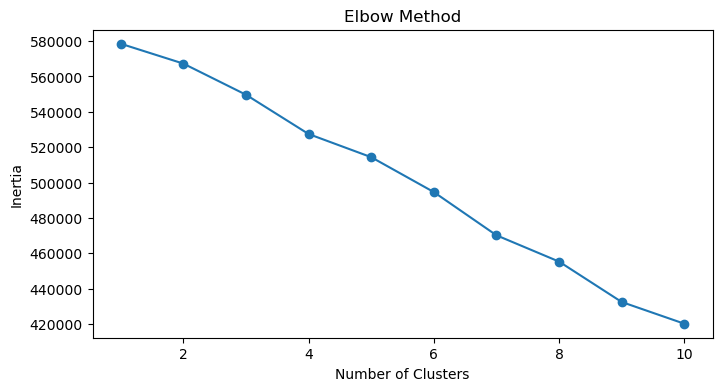

In [31]:
plt.figure(figsize=(8,4))
plt.plot(range(1,11),inertia,marker='o')

plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.show()

# K-means
- 클러스터링에서 가장 많이 쓰이는 알고리즘
- 성능이 좋다

In [32]:
kmeans = KMeans(n_clusters=3)
kmeans.fit_transform(scaled_features)

array([[ 9.77035574,  9.37335156,  7.11223627],
       [ 9.61775476,  9.10594649,  6.93287815],
       [ 9.4680056 ,  8.69785123,  4.43764745],
       ...,
       [15.00290398, 14.29381161, 12.24610913],
       [12.56963926, 11.69379813,  9.11233533],
       [15.16739442, 14.51212274, 12.41046623]])

In [33]:
# kmenas = KMeans(n_clusters=3)
# kmeans = KMeans(n_clusters=i)
# kmeans.fit(scaled_features)
# inertia.append(kmeans.inertia_)

In [36]:
kmeans = KMeans(n_clusters=6,random_state=42)
df_encoded['cluster'] = kmeans.fit_predict(scaled_features)
df_encoded['cluster']

0        3
1        3
5        3
6        3
7        3
        ..
20345    3
20356    3
20361    3
20362    3
20363    3
Name: cluster, Length: 10713, dtype: int32

In [35]:
scaled_features
# 몇번 째 클러스터에 포함돼있는지 나온다.

array([[-0.25097286,  0.78706603,  1.78001261, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       [-0.25097286, -0.61473586,  0.63519211, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       [-0.25097286, -0.61473586, -1.65444889, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       ...,
       [-0.25097286, -0.61473586, -1.65444889, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       [-0.25097286, -0.61473586, -1.65444889, ..., -0.25352668,
        -0.13580434, -0.1046255 ],
       [ 2.69068163, -0.61473586, -0.50962839, ..., -0.25352668,
        -0.13580434, -0.1046255 ]])

In [37]:
df_encoded

,sweet,acidity,body,tannin,price,year,ml,nation_Argentina,nation_Australia,nation_Austria,nation_Bulgaria,nation_Canada,nation_Chile,nation_France,nation_Germany,nation_Greece,nation_Hungary,nation_Italy,nation_Korea,nation_Moldova,nation_New Zealand,nation_Others,nation_Portugal,nation_Romania,nation_Slovenia,nation_Spain,nation_USA,nation_the Republic of South Africa,type_Etc,type_Fortified,type_Hard,type_Korean,type_Red,type_Rose,type_Sparkling,type_White,local1_Aconcagua,local1_Bordeaux,local1_Bourgogne,local1_California,local1_Central Valley,local1_Champagne,local1_Loire,local1_Maipo Valley,local1_Mendoza,local1_Others,local1_Piemonte,local1_Rapel Valley,local1_Rhone,local1_Rioja,local1_Sicilia,local1_South Australia,local1_South Island,local1_Southern France,local1_Toscana,local1_Veneto,local1_Washington State,cluster
0,1,4,5,4,220000,2014,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1,3,4,4,110000,2016,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5,1,3,2,3,21000,2011,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
6,1,4,2,1,21000,2010,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
7,1,3,2,3,19000,2017,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20345,1,4,3,3,109000,2017,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
20356,1,4,2,1,40000,2020,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
20361,1,3,2,1,40000,2020,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
20362,1,3,2,1,40000,2020,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [38]:
# Price를 뺀 x값들을 스탠다드 스케일링하여 모델에 잘 적용시키려고 빼논 것.
# predict는 원래 df 원본 중 cluster라는 컬럼에 넣으면 된다.

# 선형회귀
- 클러스터 숫자 마다 데이터들을 분배하여 데이터 군집마다의 선형회귀에서 모델의 결과값을 보고싶다.

In [39]:
# 모델 선언
# Polynomial은 다차회귀.x^2까지 들어간다.
# 릿지와 라쏘는 정규화 특성. 이상치 데이터 판단할 때 편하다.
# 경사하강법 : 딥러닝을 활용한 선형회귀식
models = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'ElasticNet' : ElasticNet(),
    'GradientBoostingRegressor' : GradientBoostingRegressor(),
    'PolynomialRegression' : make_pipeline(PolynomialFeatures(degree=2),LinearRegression())
}

In [40]:
X = scaled_features
y = df_encoded['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [42]:
models.items()

dict_items([('LinearRegression', LinearRegression()), ('Ridge', Ridge()), ('Lasso', Lasso()), ('ElasticNet', ElasticNet()), ('GradientBoostingRegressor', GradientBoostingRegressor()), ('PolynomialRegression', Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]))])

In [44]:
for name,model in models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)
    print(f'{name} R2 : {r2}')
    
# r2는 0 ~ 1 사이의 값을 갖는데, 음수가 나왔단 것은 전혀 예측하지 못했다는 점..

LinearRegression R2 : 0.20266362631067403
Ridge R2 : 0.20253265235487927


/Users/t2023-m0093/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.486e+13, tolerance: 9.666e+10
  model = cd_fast.enet_coordinate_descent(


Lasso R2 : 0.20253303810668777
ElasticNet R2 : 0.18158930985911326
GradientBoostingRegressor R2 : 0.3322378191302843
PolynomialRegression R2 : -3.8887609768185496e+19


In [45]:
df_encoded.head()

,sweet,acidity,body,tannin,price,year,ml,nation_Argentina,nation_Australia,nation_Austria,nation_Bulgaria,nation_Canada,nation_Chile,nation_France,nation_Germany,nation_Greece,nation_Hungary,nation_Italy,nation_Korea,nation_Moldova,nation_New Zealand,nation_Others,nation_Portugal,nation_Romania,nation_Slovenia,nation_Spain,nation_USA,nation_the Republic of South Africa,type_Etc,type_Fortified,type_Hard,type_Korean,type_Red,type_Rose,type_Sparkling,type_White,local1_Aconcagua,local1_Bordeaux,local1_Bourgogne,local1_California,local1_Central Valley,local1_Champagne,local1_Loire,local1_Maipo Valley,local1_Mendoza,local1_Others,local1_Piemonte,local1_Rapel Valley,local1_Rhone,local1_Rioja,local1_Sicilia,local1_South Australia,local1_South Island,local1_Southern France,local1_Toscana,local1_Veneto,local1_Washington State,cluster
0,1,4,5,4,220000,2014,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1,3,4,4,110000,2016,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5,1,3,2,3,21000,2011,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
6,1,4,2,1,21000,2010,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
7,1,3,2,3,19000,2017,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3


In [46]:
df_encoded['cluster'].unique()

array([3, 0, 1, 5, 4, 2], dtype=int32)

In [50]:
results = []
for cluster in df_encoded['cluster'].unique():
    
    cluster_data = df_encoded[df_encoded['cluster'] == cluster]
    X = cluster_data.drop(['price','cluster'],axis=1)
    y = cluster_data['price']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    
    cluster_results = {'Cluster':cluster}
    for name, model in models.items():
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test,y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test,y_pred)
        
        cluster_results[f'{name} RMSE'] = rmse
        cluster_results[f'{name} R2'] = r2
    results.append(cluster_results)

/Users/t2023-m0093/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.949e+13, tolerance: 6.524e+10
  model = cd_fast.enet_coordinate_descent(


In [51]:
results

[{'Cluster': 3,
  'LinearRegression RMSE': 234578.4088385203,
  'LinearRegression R2': 0.22118167258362653,
  'Ridge RMSE': 234580.32038666232,
  'Ridge R2': 0.2211689795587234,
  'Lasso RMSE': 234572.65179733885,
  'Lasso R2': 0.22121989975198753,
  'ElasticNet RMSE': 249405.25896142246,
  'ElasticNet R2': 0.11961769646137621,
  'GradientBoostingRegressor RMSE': 211563.17041202373,
  'GradientBoostingRegressor R2': 0.3665093287377862,
  'PolynomialRegression RMSE': 261566.95307643208,
  'PolynomialRegression R2': 0.031664536054276216},
 {'Cluster': 0,
  'LinearRegression RMSE': 374049.4757467758,
  'LinearRegression R2': 0.12568759807110097,
  'Ridge RMSE': 373947.3617781479,
  'Ridge R2': 0.1261649002917975,
  'Lasso RMSE': 374048.1985689977,
  'Lasso R2': 0.12569356867411974,
  'ElasticNet RMSE': 381839.7790302442,
  'ElasticNet R2': 0.08888986410967414,
  'GradientBoostingRegressor RMSE': 372528.0557637166,
  'GradientBoostingRegressor R2': 0.13278554209001148,
  'PolynomialRegress

In [52]:
pd.DataFrame(results)

,Cluster,LinearRegression RMSE,LinearRegression R2,Ridge RMSE,Ridge R2,Lasso RMSE,Lasso R2,ElasticNet RMSE,ElasticNet R2,GradientBoostingRegressor RMSE,GradientBoostingRegressor R2,PolynomialRegression RMSE,PolynomialRegression R2
0,3,234578.408839,0.221182,234580.320387,0.221169,234572.651797,0.221220,249405.258961,0.119618,211563.170412,0.366509,2.615670e+05,3.166454e-02
1,0,374049.475747,0.125688,373947.361778,0.126165,374048.198569,0.125694,381839.779030,0.088890,372528.055764,0.132786,3.474962e+12,-7.545858e+13
2,1,161086.317726,0.205988,161333.349895,0.203551,161087.557575,0.205976,164874.440527,0.168205,148728.938461,0.323137,1.688633e+05,1.274696e-01
3,5,163629.455163,0.169137,163609.784415,0.169336,163629.461720,0.169136,167350.570753,0.130917,154898.310657,0.255439,4.239879e+05,-4.578451e+00
4,4,94744.749973,-1.766117,82440.128712,-1.094293,90939.624306,-1.548394,55683.857783,0.044526,111244.637078,-2.813453,7.199641e+05,-1.587283e+02
5,2,98005.228439,-1.168882,61294.667068,0.151635,98009.190948,-1.169058,59160.057135,0.209695,98426.274251,-1.187558,7.945113e+07,-1.425402e+06


In [53]:
pd.DataFrame(results).T

,0,1,2,3,4,5
Cluster,3.000000,0.000000e+00,1.000000,5.000000,4.000000,2.000000e+00
LinearRegression RMSE,234578.408839,3.740495e+05,161086.317726,163629.455163,94744.749973,9.800523e+04
LinearRegression R2,0.221182,1.256876e-01,0.205988,0.169137,-1.766117,-1.168882e+00
Ridge RMSE,234580.320387,3.739474e+05,161333.349895,163609.784415,82440.128712,6.129467e+04
Ridge R2,0.221169,1.261649e-01,0.203551,0.169336,-1.094293,1.516348e-01
Lasso RMSE,234572.651797,3.740482e+05,161087.557575,163629.461720,90939.624306,9.800919e+04
Lasso R2,0.221220,1.256936e-01,0.205976,0.169136,-1.548394,-1.169058e+00
ElasticNet RMSE,249405.258961,3.818398e+05,164874.440527,167350.570753,55683.857783,5.916006e+04
ElasticNet R2,0.119618,8.888986e-02,0.168205,0.130917,0.044526,2.096952e-01
GradientBoostingRegressor RMSE,211563.170412,3.725281e+05,148728.938461,154898.310657,111244.637078,9.842627e+04


In [54]:
# 설명력이 높은 모델(r2, gradientBoosting 등) 갖고 지지고 볶고
# 선형회귀 할 때 절대 y값을 건드리면 안 되는데.. 건들면 성능 높아짐.

In [55]:
np.log1p(df_encoded['price'])
# 원래 만 ~ 십만단위 였는데 로그함수로 눌러버림.
# 모델이 예측해야 할 값 범위가 줄어들었음.

0        12.301387
1        11.608245
5         9.952325
6         9.952325
7         9.852247
           ...    
20345    11.599112
20356    10.596660
20361    10.596660
20362    10.596660
20363    10.915107
Name: price, Length: 10713, dtype: float64

In [56]:
df_encoded['price'] = np.log1p(df_encoded['price'])
df_encoded

,sweet,acidity,body,tannin,price,year,ml,nation_Argentina,nation_Australia,nation_Austria,nation_Bulgaria,nation_Canada,nation_Chile,nation_France,nation_Germany,nation_Greece,nation_Hungary,nation_Italy,nation_Korea,nation_Moldova,nation_New Zealand,nation_Others,nation_Portugal,nation_Romania,nation_Slovenia,nation_Spain,nation_USA,nation_the Republic of South Africa,type_Etc,type_Fortified,type_Hard,type_Korean,type_Red,type_Rose,type_Sparkling,type_White,local1_Aconcagua,local1_Bordeaux,local1_Bourgogne,local1_California,local1_Central Valley,local1_Champagne,local1_Loire,local1_Maipo Valley,local1_Mendoza,local1_Others,local1_Piemonte,local1_Rapel Valley,local1_Rhone,local1_Rioja,local1_Sicilia,local1_South Australia,local1_South Island,local1_Southern France,local1_Toscana,local1_Veneto,local1_Washington State,cluster
0,1,4,5,4,12.301387,2014,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1,3,4,4,11.608245,2016,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5,1,3,2,3,9.952325,2011,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
6,1,4,2,1,9.952325,2010,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
7,1,3,2,3,9.852247,2017,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20345,1,4,3,3,11.599112,2017,750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
20356,1,4,2,1,10.596660,2020,750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
20361,1,3,2,1,10.596660,2020,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
20362,1,3,2,1,10.596660,2020,750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [57]:
results = []
for cluster in df_encoded['cluster'].unique():
    
    cluster_data = df_encoded[df_encoded['cluster'] == cluster]
    X = cluster_data.drop(['price','cluster'],axis=1)
    y = cluster_data['price']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    
    cluster_results = {'Cluster':cluster}
    for name, model in models.items():
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test,y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test,y_pred)
        
        cluster_results[f'{name} RMSE'] = rmse
        cluster_results[f'{name} R2'] = r2
    results.append(cluster_results)
results
# 설명력이 0.6까지도 올라감.

[{'Cluster': 3,
  'LinearRegression RMSE': 0.6514386877584194,
  'LinearRegression R2': 0.5418028475824429,
  'Ridge RMSE': 0.6512506643951486,
  'Ridge R2': 0.5420673063514916,
  'Lasso RMSE': 0.962513850655671,
  'Lasso R2': -0.00027466114285679133,
  'ElasticNet RMSE': 0.958996761739685,
  'ElasticNet R2': 0.007022121795313363,
  'GradientBoostingRegressor RMSE': 0.6078487084796846,
  'GradientBoostingRegressor R2': 0.6010703752577539,
  'PolynomialRegression RMSE': 2.5877146291378734,
  'PolynomialRegression R2': -6.229995949357848},
 {'Cluster': 0,
  'LinearRegression RMSE': 0.8954338556856012,
  'LinearRegression R2': 0.3020509297048498,
  'Ridge RMSE': 0.8953299434644433,
  'Ridge R2': 0.30221290979867144,
  'Lasso RMSE': 1.079166651385947,
  'Lasso R2': -0.013756715393328012,
  'ElasticNet RMSE': 1.0677751844220384,
  'ElasticNet R2': 0.007532352428188838,
  'GradientBoostingRegressor RMSE': 0.8628315660046219,
  'GradientBoostingRegressor R2': 0.35194963173856897,
  'Polynomia

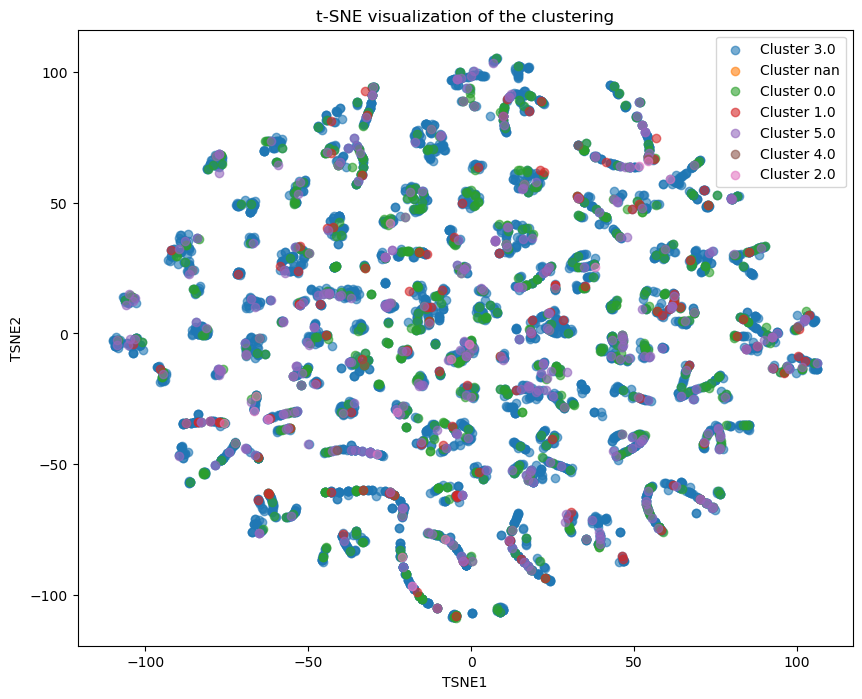

In [58]:
# t-SNE 시각화
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = df_encoded['cluster']

plt.figure(figsize=(10, 8))
for cluster in df_tsne['cluster'].unique():
    cluster_subset = df_tsne[df_tsne['cluster'] == cluster]
    plt.scatter(cluster_subset['TSNE1'], cluster_subset['TSNE2'], label=f'Cluster {cluster}', alpha=0.6)
plt.title('t-SNE visualization of the clustering')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend()
plt.show()

- 58개 차원으로 클러스터링 했기 때문에 인간이 볼 수 있는 시각화는 불가능
- 직접 만든 위에건 군집이 잘 된 경우는 아니다.
- 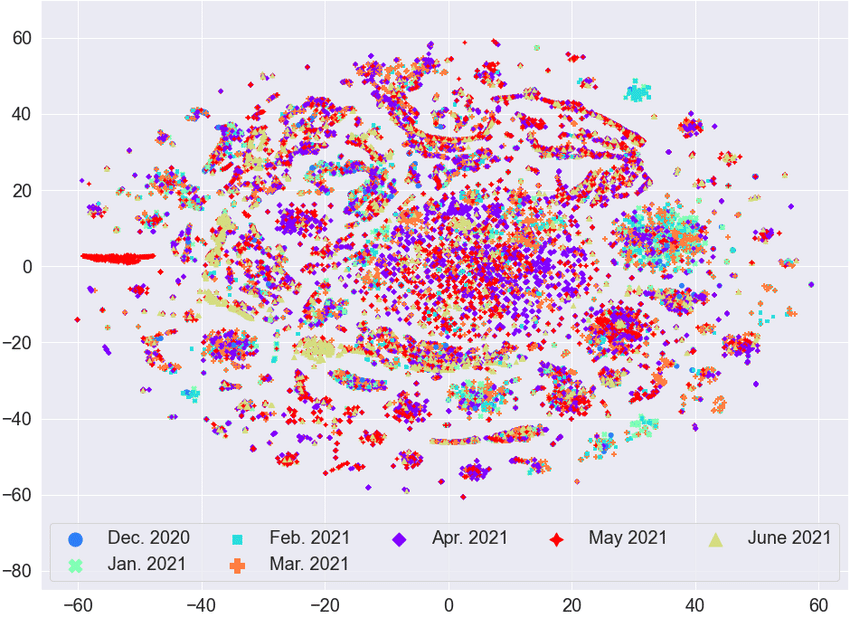